In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import norm, skew #for some statistics

### Loading Data

In [3]:
#Carga de datos de propiedades
train = pd.read_csv('train_home.csv')
labels=train["SalePrice"]
test = pd.read_csv('test_home.csv')
data = pd.concat([train,test],ignore_index=True)
data = data.drop("SalePrice", 1)
test_ids = test['Id']

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Data dimension: Test and Train

In [6]:
print("Train Shape:", train.shape)
print("Train Duplicated data :", train.duplicated().sum())

Train Shape: (1460, 81)
Train Duplicated data : 0


In [7]:
print("Train Shape:", test.shape)
print("Train Duplicated data :", test.duplicated().sum())

Train Shape: (1459, 80)
Train Duplicated data : 0


### Predict variable distribution

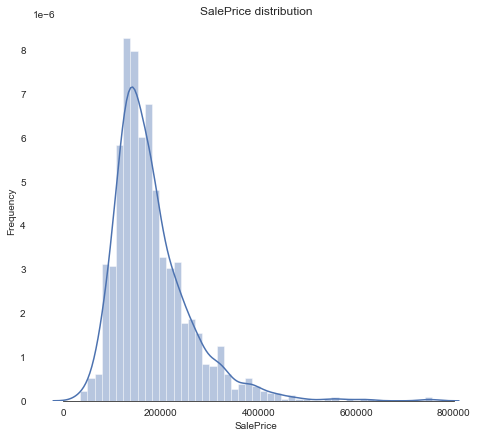

In [8]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Seaborn plot for distribution in the predict variable
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

### Kurtosis and Skewness

In [9]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Missing Values with missigno library

<AxesSubplot:>

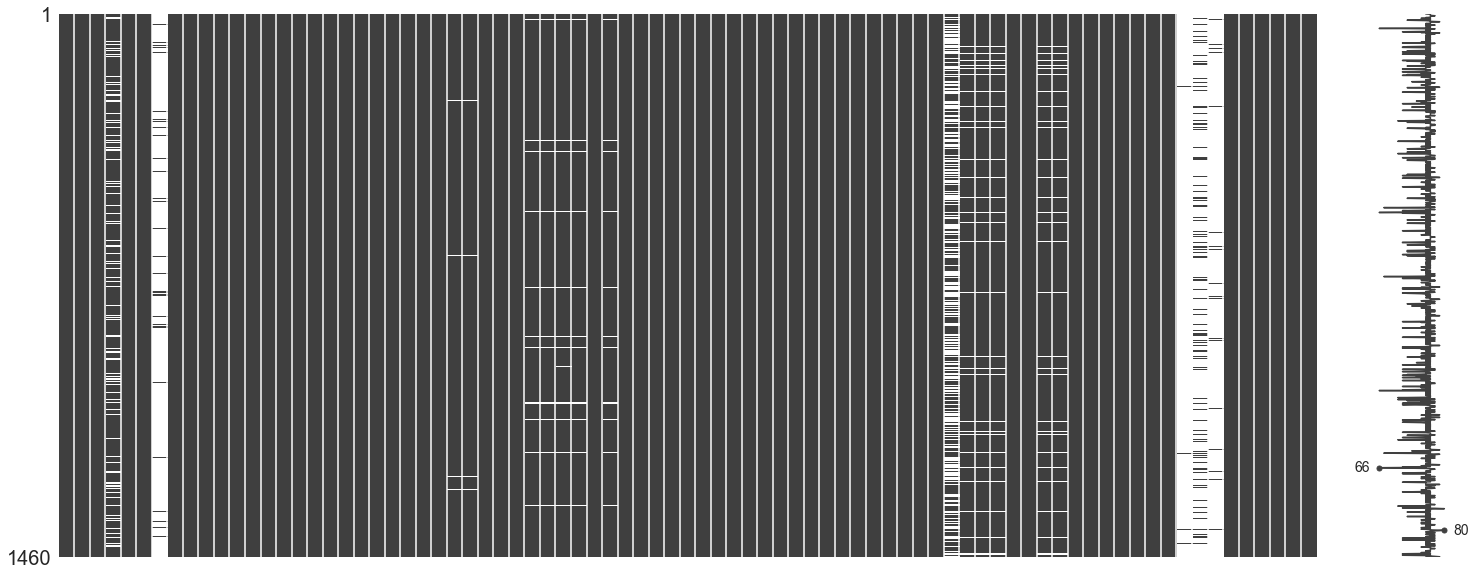

In [10]:
msno.matrix(train)

### Relationship between numerical variables: Bivariate Analysis

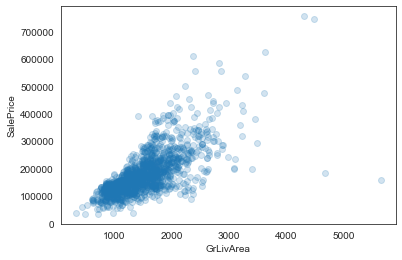

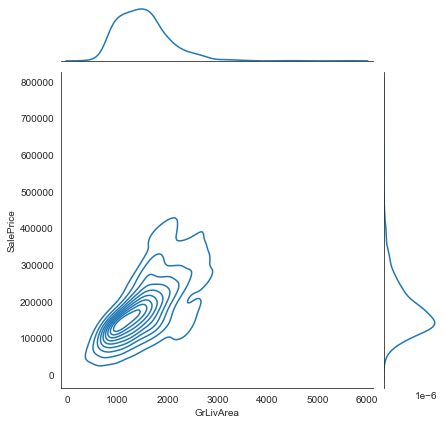

In [11]:
x = 'GrLivArea'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

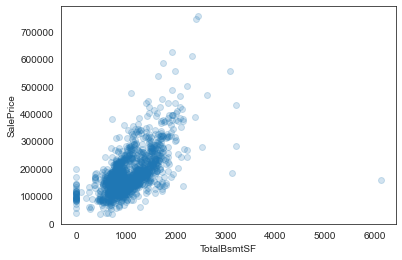

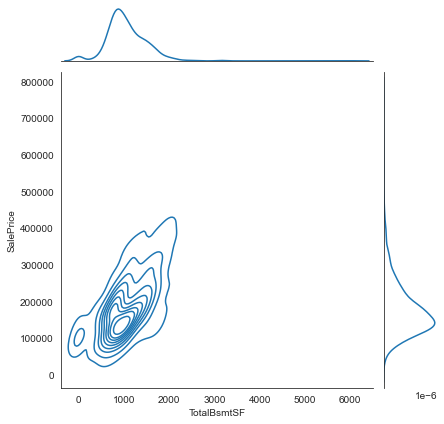

In [12]:
x = 'TotalBsmtSF'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

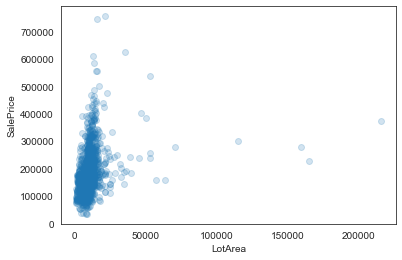

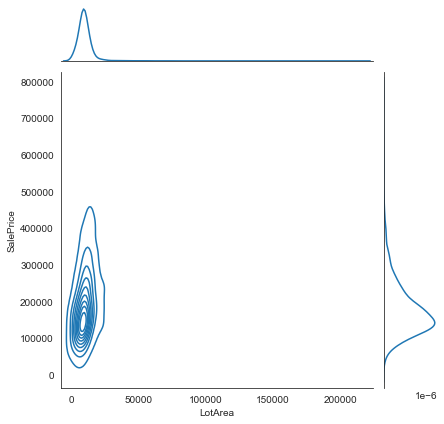

In [13]:
x = 'LotArea'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

### Relationship between categorical variables: Boxplot

(-0.5, 9.5, 0.0, 800000.0)

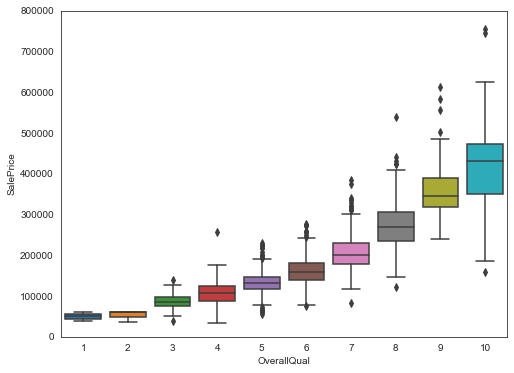

In [14]:
#Categorical variables
x = 'OverallQual'
data = pd.concat([train['SalePrice'], train[x]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=x, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

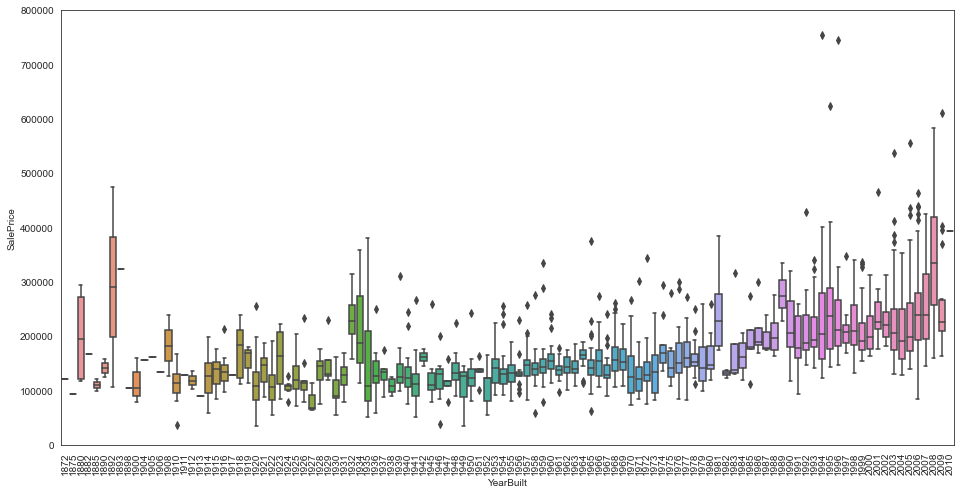

In [15]:
x = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[x]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=x, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

### Correlation Analysis

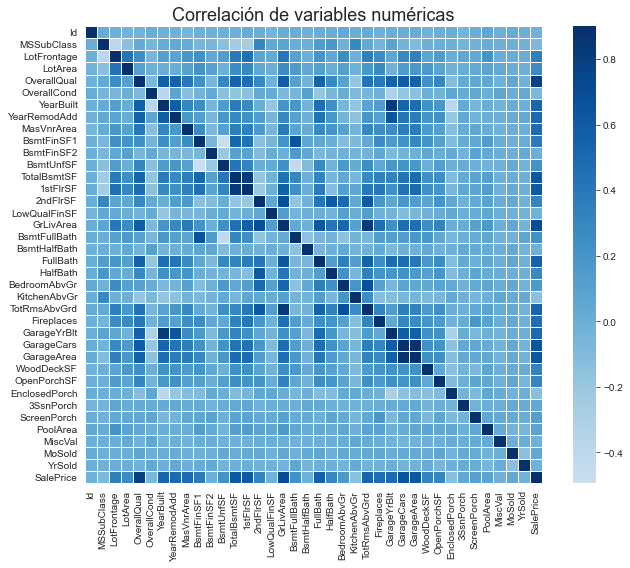

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(),
            #annot=True,
            vmax=0.9,
            linewidths=.5,
            center=0,
            #cbar=False,
            square=True,
            cmap="Blues"
            )
plt.title('Correlación de variables numéricas', fontsize=18)
plt.tight_layout()
plt.show()

### Pairplot to study the relationship between numerical variables and its distribution

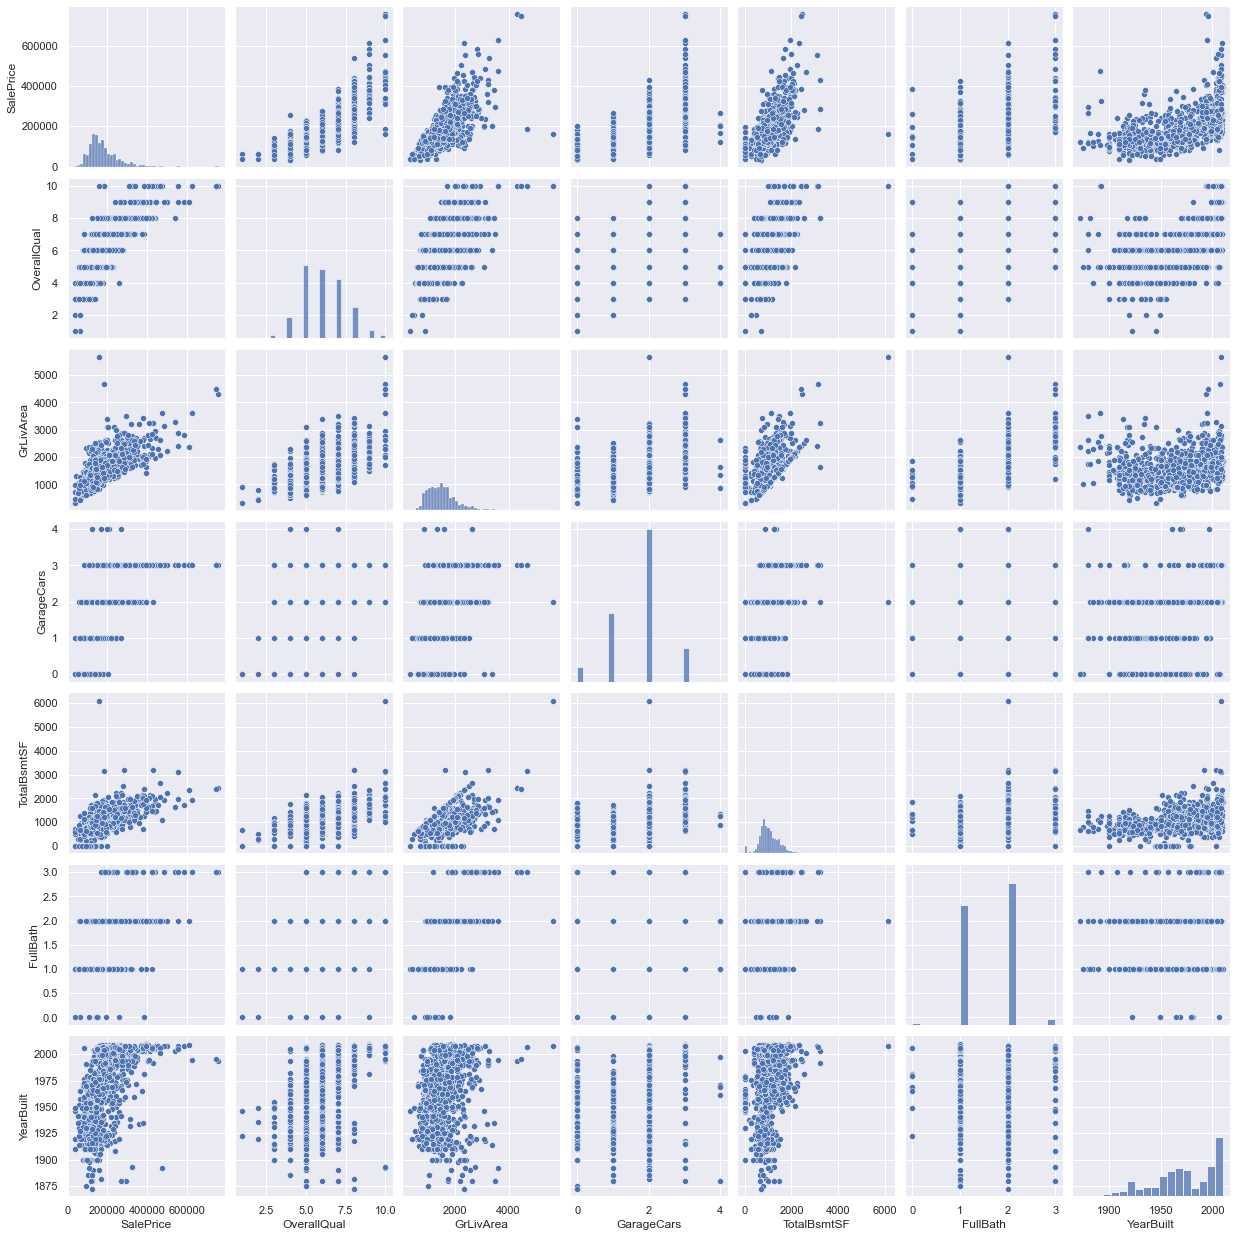

In [17]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

#### Now we study the outliers and the numerical variables, we can get the numerical variables with the get_numeric_data() method and then analyse the columns with horizontal boxplots

In [18]:
num_cols = train._get_numeric_data().columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [21]:
new_data = train._get_numeric_data().copy()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
new_data2 = new_data[cols]
new_data2.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,208500,7,1710,2,856,2,2003
1,181500,6,1262,2,1262,2,1976
2,223500,7,1786,2,920,2,2001
3,140000,7,1717,3,756,1,1915
4,250000,8,2198,3,1145,2,2000


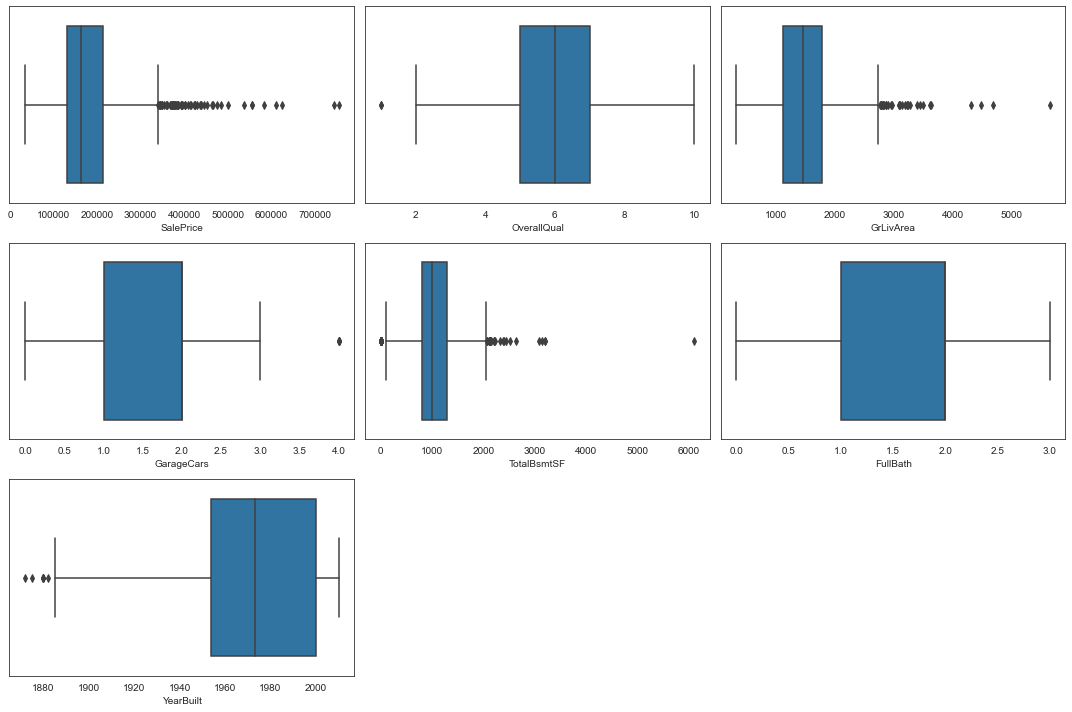

In [22]:
plt.figure(figsize=(15, 10))
pos = 1
for i in new_data2.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(x=new_data2[i])
    pos += 1
plt.tight_layout()
plt.show()

### Feature Engineering

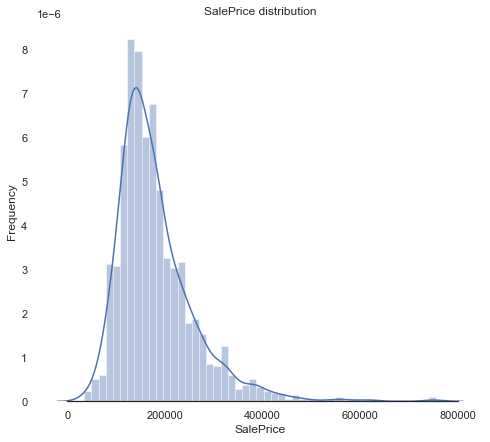

In [18]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Seaborn plot for distribution in the predict variable
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
#LOG(1+x) for predict label
train["SalePrice"] = np.log1p(train["SalePrice"])

#New distribution
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [19]:
#Inicializamos la clase
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
IQR = q3 - q1
outliers = data[
    ((data < (q1 - 1.5 * IQR)) | (data > (q3 + 1.5 * IQR)))]
print("number of outliers: " + str(len(outliers)))
print("max outlier value: " + str(outliers.max()))
print("min outlier value: " + str(outliers.min()))

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [6]:
#Dimensiones del dataframe
data_eda.get_dim()

Filas: 2919
Columnas: 80


In [7]:
#Conteo de Nulls
nans=pd.isnull(data).sum()
nans[nans>0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [9]:
# Remover la columna ID y aquellas con mas de 1k missing values
data=data.drop("Id", 1)
data=data.drop("Alley", 1)
data=data.drop("Fence", 1)
data=data.drop("MiscFeature", 1)
data=data.drop("PoolQC", 1)
data=data.drop("FireplaceQu", 1)

In [10]:
#conteo de tipos de columnas
data.dtypes.value_counts()

object     38
int64      25
float64    11
dtype: int64

In [12]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data = imp.fit_transform(data)

# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data==-np.inf]=0

In [14]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.2248857 , 0.40281429, 0.52425789, 0.62418823, 0.69580422,
       0.75944463, 0.8116806 , 0.85647038, 0.89178708, 0.92273755,
       0.94898868, 0.95842727, 0.96637545, 0.97380464, 0.97971901,
       0.98501952, 0.98918839, 0.99199181, 0.99386559, 0.99520919,
       0.99611479, 0.99695667, 0.99771023, 0.99842564, 0.9989402 ,
       0.99933882, 0.99959949, 0.99978254, 0.99988174, 0.99993998,
       0.99998599, 0.99999658, 0.99999871, 0.99999943, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [15]:
# R2 Score

def lets_try(train,labels):
    results={}
    def test_model(clf):

        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)

    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)

    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)

    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)

    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)

    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)

    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)

    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)

    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)

    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)

    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"]
    results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

lets_try(train,labels)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_base.py", line 684, in fit
    X, y = self._validate_data(
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\utils\validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "C:\Users\nicol\PycharmProjects\pythonProject\venv\lib\site-packages\pandas\core\generic.py", line 2072, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'RL'


In [17]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
